https://www.kaggle.com/datasets/wildlifedatasets/seaturtleidheads

In [159]:
import os
import random
import json
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imutils.paths import list_images
from imutils import build_montages
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Flatten,
    Activation, Lambda, concatenate, LeakyReLU
)
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from google.colab.patches import cv2_imshow
import kagglehub

In [160]:
path = kagglehub.dataset_download("wildlifedatasets/seaturtleidheads")
with open(os.path.join(path, 'annotations.json'), 'r') as f:
    data = json.load(f)

In [161]:
images_data = data['images']
df = pd.DataFrame(images_data)

In [162]:
def extract_label(path):
    return path.split('/')[1]

In [163]:
df['label'] = df['path'].apply(extract_label)
print("Unique Labels (Turtles):", df['label'].unique())

Unique Labels (Turtles): ['t281' 't124' 't182' 't101' 't415' 't041' 't297' 't267' 't163' 't021'
 't114' 't061' 't322' 't025' 't269' 't262' 't308' 't441' 't266' 't123'
 't350' 't387' 't075' 't132' 't203' 't277' 't371' 't273' 't335' 't241'
 't095' 't307' 't155' 't352' 't158' 't283' 't194' 't058' 't215' 't105'
 't254' 't330' 't045' 't204' 't052' 't225' 't202' 't263' 't177' 't070'
 't071' 't056' 't068' 't351' 't009' 't373' 't024' 't396' 't258' 't401'
 't468' 't379' 't064' 't230' 't206' 't121' 't084' 't185' 't139' 't080'
 't427' 't341' 't094' 't186' 't110' 't108' 't295' 't385' 't296' 't198'
 't270' 't085' 't246' 't112' 't003' 't301' 't252' 't363' 't250' 't164'
 't097' 't128' 't015' 't048' 't434' 't412' 't166' 't378' 't300' 't298'
 't102' 't107' 't073' 't142' 't093' 't328' 't242' 't065' 't131' 't063'
 't159' 't011' 't374' 't369' 't390' 't129' 't088' 't451' 't184' 't205'
 't089' 't026' 't238' 't219' 't433' 't237' 't345' 't216' 't285' 't183'
 't354' 't181' 't162' 't418' 't425' 't392' 't337' 't

In [164]:
image_paths = [os.path.join(path, p) for p in df['path']]
labels = df['label'].values

In [165]:
def load_images(image_paths, size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            images.append(img)
    return np.array(images)

In [166]:
images = load_images(image_paths)

In [167]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [168]:
trainX_full, testX_full, trainY_full, testY_full = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

train_indices = np.random.choice(len(trainX_full), 500, replace=False)
test_indices = np.random.choice(len(testX_full), 100, replace=False)

trainX = trainX_full[train_indices]
trainY = trainY_full[train_indices]
testX = testX_full[test_indices]
testY = testY_full[test_indices]

print(f"TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
print(f"TestX shape: {testX.shape}, TestY shape: {testY.shape}")


TrainX shape: (500, 256, 256, 3), TrainY shape: (500,)
TestX shape: (100, 256, 256, 3), TestY shape: (100,)


In [169]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []

    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]

        if len(label_to_indices[label]) > 1:
            posIdx = np.random.choice(label_to_indices[label])
            while posIdx == idxA:
                posIdx = np.random.choice(label_to_indices[label])
            posImage = images[posIdx]

            pairImages.append([currentImage, posImage])
            pairLabels.append(1)

        negLabel = np.random.choice([l for l in label_to_indices.keys() if l != label])
        negIdx = np.random.choice(label_to_indices[negLabel])
        negImage = images[negIdx]

        pairImages.append([currentImage, negImage])
        pairLabels.append(0)

    return (np.array(pairImages), np.array(pairLabels))

In [170]:
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
print(f"PairTrain shape: {pairTrain.shape}, LabelTrain shape: {labelTrain.shape}")
print(f"PairTest shape: {pairTest.shape}, LabelTest shape: {labelTest.shape}")

PairTrain shape: (888, 2, 256, 256, 3), LabelTrain shape: (888,)
PairTest shape: (121, 2, 256, 256, 3), LabelTest shape: (121,)


In [172]:
IMG_SHAPE = (256, 256, 3)
BATCH_SIZE = 16
EPOCHS = 10

In [173]:
def build_siamese_model(inputShape, embeddingDim=128):
    inputs = Input(inputShape)

    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    avgPool = GlobalAveragePooling2D()(x)
    maxPool = GlobalMaxPooling2D()(x)
    x = concatenate([avgPool, maxPool])

    x = Dense(embeddingDim, kernel_regularizer=l2(1e-3))(x)
    outputs = Activation("linear")(x)

    model = Model(inputs, outputs)
    return model

In [174]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [175]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [176]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [177]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [178]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [179]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.5685 - loss: 6.8393 - val_accuracy: 0.8264 - val_loss: 0.7674
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.5423 - loss: 1.7821 - val_accuracy: 0.8264 - val_loss: 0.7016
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5695 - loss: 1.2995 - val_accuracy: 0.8264 - val_loss: 0.7229
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5700 - loss: 1.1707 - val_accuracy: 0.8264 - val_loss: 0.7467
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5774 - loss: 1.0733 - val_accuracy: 0.8264 - val_loss: 0.7499
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5274 - loss: 1.1004 - val_accuracy: 0.8099 - val_loss: 0.7410
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5507 - loss: 1.0023 - val_accuracy: 0.7934 - val_loss: 0.7566
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5663 - loss: 0.9573 - val_accura

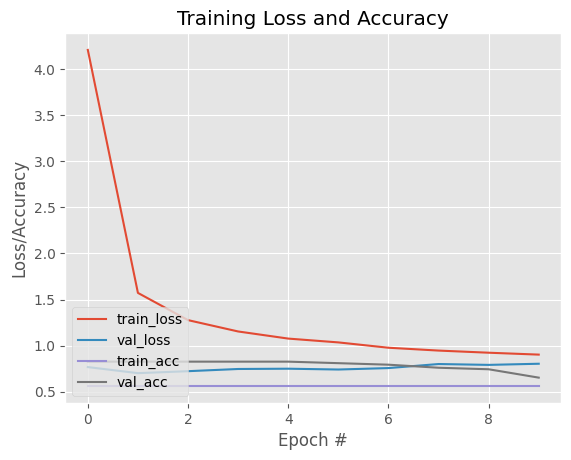

In [180]:
plot_training(history)

In [181]:
model.save("siamese_model.keras")

In [182]:
model = load_model("siamese_model.keras", custom_objects={"euclidean_distance": euclidean_distance})

In [183]:
def generate_test_pairs(df, base_path, num_pairs=5):
    positive_pairs = []
    negative_pairs = []

    folder_to_images = df.groupby('label')['path'].apply(list).to_dict()

    for folder, paths in folder_to_images.items():
        if len(paths) > 1:
            for _ in range(num_pairs):
                pathA, pathB = random.sample(paths, 2)
                positive_pairs.append((pathA, pathB))
            if len(positive_pairs) >= num_pairs:
                break

    labels = list(folder_to_images.keys())
    while len(negative_pairs) < num_pairs:
        labelA, labelB = random.sample(labels, 2)
        pathA = random.choice(folder_to_images[labelA])
        pathB = random.choice(folder_to_images[labelB])
        negative_pairs.append((pathA, pathB))

    test_pairs = positive_pairs + negative_pairs
    random.shuffle(test_pairs)
    return test_pairs

In [184]:
num_pairs = 5
test_pairs = generate_test_pairs(df, path, num_pairs=num_pairs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Pair 0: True Label: Negative, Predicted Similarity: 0.49


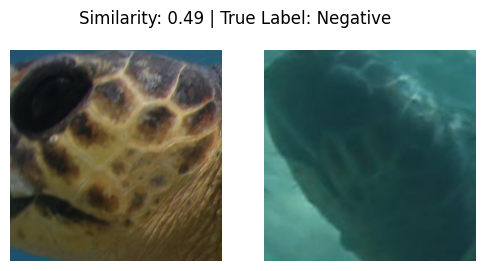

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Pair 1: True Label: Negative, Predicted Similarity: 0.31


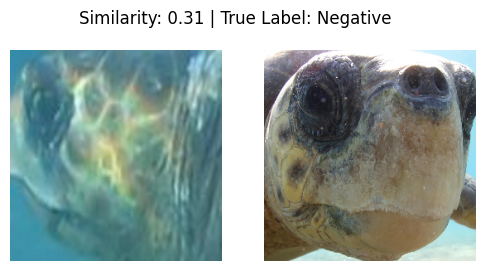

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pair 2: True Label: Negative, Predicted Similarity: 0.45


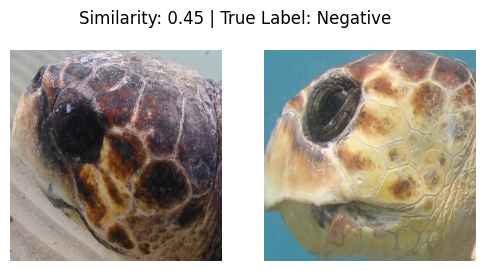

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Pair 3: True Label: Positive, Predicted Similarity: 0.43


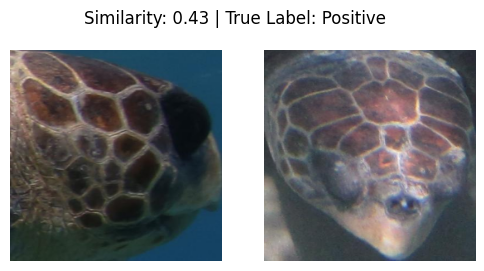

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Pair 4: True Label: Positive, Predicted Similarity: 0.49


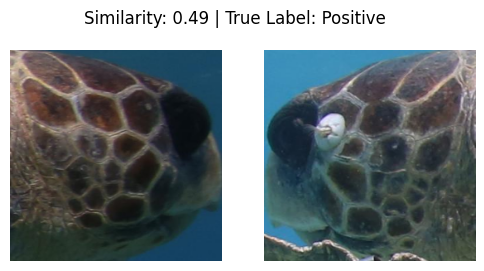

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Pair 5: True Label: Positive, Predicted Similarity: 0.52


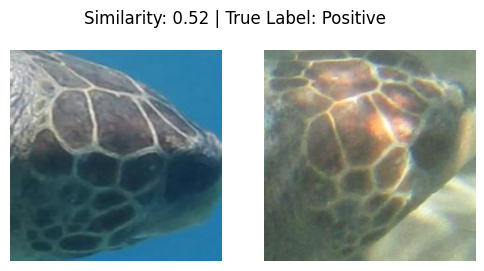

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pair 6: True Label: Positive, Predicted Similarity: 0.49


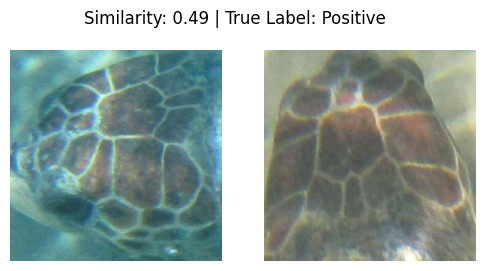

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Pair 7: True Label: Negative, Predicted Similarity: 0.44


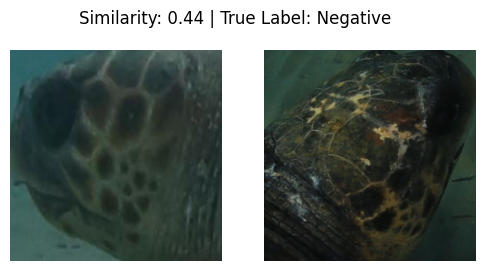

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Pair 8: True Label: Negative, Predicted Similarity: 0.46


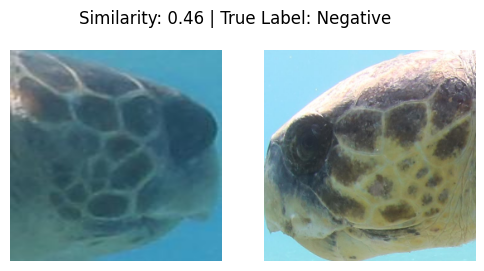

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Pair 9: True Label: Positive, Predicted Similarity: 0.53


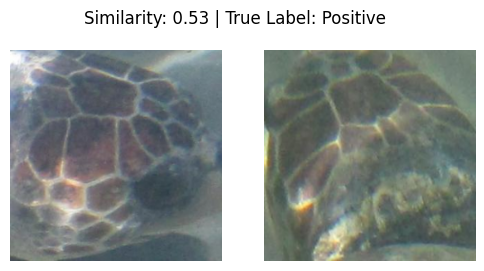

In [185]:
for i, (pathA, pathB) in enumerate(test_pairs):
    labelA = os.path.basename(os.path.dirname(pathA))
    labelB = os.path.basename(os.path.dirname(pathB))
    true_label = "Positive" if labelA == labelB else "Negative"

    imageA = cv2.imread(os.path.join(path, pathA))
    imageB = cv2.imread(os.path.join(path, pathB))

    imageA = cv2.resize(imageA, (256, 256))
    imageB = cv2.resize(imageB, (256, 256))

    origA = imageA.copy()
    origB = imageB.copy()

    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)

    preds = model.predict([imageA, imageB])
    proba = preds[0][0]

    print(f"Pair {i}: True Label: {true_label}, Predicted Similarity: {proba:.2f}")

    fig = plt.figure(f"Pair #{i + 1}", figsize=(6, 3))
    plt.suptitle(f"Similarity: {proba:.2f} | True Label: {true_label}")

    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(origA, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(origB, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()
